In [1]:
import os
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
class VideoProcessor:
    def __init__(self, 
                 modelFile="../models/res10_300x300_ssd_iter_140000.caffemodel",
                 configFile = "../models/deploy.prototxt",
                 landmarkFile = "../models/shape_predictor_68_face_landmarks.dat",
                 right_eye_file ='../models/haarcascade_righteye_2splits.xml',
                 left_eye_file ='../models/haarcascade_lefteye_2splits.xml',
                 mouth_file ='../models/haarcascade_smile.xml',
                 max_interations = 30,
                 conf_threshold = 0.60,
                 normalized_dim = 128):
        self.modelFile = modelFile
        self.configFile = configFile
        self.max_interations = max_interations
        self.conf_threshold = conf_threshold
        self.normalized_dim = normalized_dim
        self.net = cv2.dnn.readNetFromCaffe(self.configFile, self.modelFile)
        self.right_eye_casc = cv2.CascadeClassifier(right_eye_file)
        self.left_eye_casc = cv2.CascadeClassifier(left_eye_file)
        self.mouth_casc = cv2.CascadeClassifier(mouth_file)
        self.mean = 128
        self.min_YCrCb = np.array([0,133,77],np.uint8)
        self.max_YCrCb = np.array([235,173,127],np.uint8)
        self.h = 260
        self.w = 208
        
        #self.min_HSV = np.array([0, 48, 80], dtype = "uint8")
        #self.max_HSV = np.array([20, 255, 255], dtype = "uint8")
        self.min_HSV = np.array([0, 58, 30], dtype = "uint8")
        self.max_HSV = np.array([33, 255, 255], dtype = "uint8")

    def extract_face_box(self, img):
        (h, w) = img.shape[:2]
        face_box = None
        blob = cv2.dnn.blobFromImage(cv2.resize(img, (300, 300)), 1.0, (300, 300), (103.93, 116.77, 123.68))
        self.net.setInput(blob)
        detections = self.net.forward()
        for i in range(detections.shape[2]):
            if detections[0, 0, i, 2] > self.conf_threshold:
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                iw = box[2] - box[0]
                ih = box[3] - box[1]
                if ih > 100 and ih < 600 and iw > 50 and iw < 500:
                    face_box = box.astype("int")
                    break
                    
        return face_box

    def extract_random_faces(self, filename, num_faces=10, resized_face=True, format_HSV=True, diff_mean=True):
        captured_faces = []
        iterations = 0
        v_cap = cv2.VideoCapture(filename)
        v_length = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        while len(captured_faces) < num_faces and iterations < self.max_interations:
            iterations += 1
            v_cap.set(1, np.random.randint(v_length)-1)
            
            ret, img = v_cap.read()
        
            if ret == True:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                face_box = self.extract_face_box(img)
                
                if face_box is not None:
                    (x1, y1, x2, y2) = face_box
                    (x1, y1, x2, y2) = ((x1+x2)//2-self.w//2, (y1+y2)//2-self.h//2,
                                        (x1+x2)//2+self.w//2, (y1+y2)//2+self.h//2)
                    if x1 < 0:
                        x1 = 0
                        x2 = self.w
                    if y1 < 0:
                        y1 = 0
                        y2 = self.h

                    face = img[y1:y2, x1:x2]
                    
                    if resized_face:
                        face = cv2.resize(face, (self.normalized_dim,self.normalized_dim))
                        
                    if format_HSV:
                        face = cv2.cvtColor(face,cv2.COLOR_RGB2HSV)
                    
                    if diff_mean:
                        face = cv2.absdiff(self.mean,face)
                    
                    captured_faces.append(face)
        
        v_cap.release()
    
        return captured_faces


    def right_eye(self, face):
        right_eye = self.right_eye_casc.detectMultiScale(
            face,
            scaleFactor=1.1,
            minNeighbors=4,
            flags=cv2.CASCADE_FIND_BIGGEST_OBJECT)
        return right_eye[0]

    def left_eye(self, face):
        right_eye = self.left_eye_casc.detectMultiScale(
            face,
            scaleFactor=1.1,
            minNeighbors=4,
            flags=cv2.CASCADE_FIND_BIGGEST_OBJECT)
        return right_eye[0]

    def mouth(self, face):
        right_eye = self.mouth_casc.detectMultiScale(
            face,
            scaleFactor=1.1,
            minNeighbors=4,
            flags=cv2.CASCADE_FIND_BIGGEST_OBJECT)
        return right_eye[0]


    def extract_diff(self, filename, nframe = 42, num_diff = 1):
        captured_diff = np.empty(shape=(0,d,d,3), dtype=np.int8)
        iterations = 0
        v_cap = cv2.VideoCapture(filename)
        v_length = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        while len(captured_diff) < num_diff and iterations < self.max_interations:
            iterations += 1
            v_cap.set(1, nframe)
            ret, img_base = v_cap.read()
            if ret == True:
                v_cap.set(1, nframe + self.nframesdiff)
                ret, img = v_cap.read()
                
            if ret == True:
                img_base = cv2.cvtColor(img_base, cv2.COLOR_BGR2RGB)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                face1 = cv2.resize(self.extract_face(img_base), (self.normalized_dim,self.normalized_dim))
                face2 = cv2.resize(self.extract_face(img), (self.normalized_dim,self.normalized_dim))
                if type(face1) == type(face2):
                    face_diff = cv2.absdiff(face2,face1)
                    # face_diff = cv2.absdiff(self.mean,face_diff)
                    face_diff = cv2.normalize(face_diff,None,0,255,cv2.NORM_MINMAX)
                    if face_diff is not None:
                        captured_diff = np.append(captured_diff,[face_diff],axis=0)
        
        # When everything done, release the video capture and video write objects
        v_cap.release()
        
        # Closes all the frames
        cv2.destroyAllWindows() 

        return captured_diff

    def extract_motion(self, filename, nframe = 42, num_motions = 1):
        captured_motions = np.empty(shape=(0,d,d,3), dtype=np.int8)
        hsv = np.empty(shape=(d,d,3), dtype=np.uint8)
        iterations = 0
        v_cap = cv2.VideoCapture(filename)
        v_length = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        while len(captured_motions) < num_motions and iterations < self.max_interations:
            iterations += 1
            v_cap.set(1, nframe)
            ret, img_base = v_cap.read()
            if ret == True:
                v_cap.set(1, nframe + self.nframesdiff)
                ret, img = v_cap.read()
                
            if ret == True:
                img_base = cv2.cvtColor(img_base, cv2.COLOR_BGR2RGB)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                face1 = cv2.resize(self.extract_face(img_base), (self.normalized_dim,self.normalized_dim))
                face2 = cv2.resize(self.extract_face(img), (self.normalized_dim,self.normalized_dim))
                
                if type(face1) == type(face2):
                    face1 = cv2.cvtColor(face1, cv2.COLOR_RGB2GRAY)
                    face2 = cv2.cvtColor(face2, cv2.COLOR_RGB2GRAY)
                    hsv[...,1] = 255

                    flow = cv2.calcOpticalFlowFarneback(face1, face2, None, 0.5, 3, 15, 3, 5, 1.2, 0)
                    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
                    hsv[...,0] = ang*180/np.pi/2
                    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
                    bgr = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)
                    if bgr is not None:
                        captured_motions = np.append(captured_motions,[bgr],axis=0)
        
        # When everything done, release the video capture and video write objects
        v_cap.release()
        
        # Closes all the frames
        cv2.destroyAllWindows() 

        return captured_motions

    def extract_skin(self, image):
        imageYCrCb = cv2.cvtColor(image,cv2.COLOR_RGB2YCR_CB)
        skinRegionYCrCb = cv2.inRange(imageYCrCb,self.min_YCrCb,self.max_YCrCb)
        return (skinRegionYCrCb/255).sum(), cv2.bitwise_and(image, image, mask = skinRegionYCrCb)

    def extract_skin_hue(self, image):
        imagehsv = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
        skinRegionhsv = cv2.inRange(imagehsv,self.min_HSV,self.max_HSV)
        return cv2.bitwise_and(image, image, mask = skinRegionhsv)

    def extract(self, filename, output):
        nfaces = 0
        last_face_box = None
        v_cap = cv2.VideoCapture(filename)
        fourcc = cv2.VideoWriter_fourcc(*'MP4V')
        v_out = cv2.VideoWriter(output,fourcc, 30, (2*self.normalized_dim,self.normalized_dim))

        while True:
            ret, img = v_cap.read()
            if ret != True:
                break
            
            # extract face
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            face_box = self.extract_face_box(img)

            if face_box is None and last_face_box is not None:
                face_box = last_face_box
            
            if face_box is not None:
                z = np.zeros((self.normalized_dim,self.normalized_dim,3),dtype="uint8")
                (x1, y1, x2, y2) = face_box
                (x1, y1, x2, y2) = ((x1+x2)//2-self.w//2, (y1+y2)//2-self.h//2,
                                    (x1+x2)//2+self.w//2, (y1+y2)//2+self.h//2)
                (npixels,face) = self.extract_skin(img[y1:y2, x1:x2])
                # face = cv2.resize(face, (self.normalized_dim,self.normalized_dim))
                (u1,u2,u3) = face.shape
                z[0:u1,0:u2,0:u3] = face
                frame = cv2.cvtColor(z, cv2.COLOR_RGB2BGR)
                last_face_box = face_box
                nfaces += 1
            else:
                frame = np.zeros((self.normalized_dim,self.normalized_dim,3),dtype="uint8")

            fig = Figure(figsize=(5, 5), dpi=100)
            canvas = FigureCanvasAgg(fig)
            ax = fig.add_subplot(111)

            color = ('b','y','r')
            face_hsv = cv2.cvtColor(face,cv2.COLOR_RGB2HSV)
            for i,col in enumerate(color):
                hist = cv2.calcHist([face_hsv],[i],None,[256],[0,256])/npixels
                ax.plot(hist,color = col)
                ax.set_ylim([.0, .3])

            canvas.draw()
            s, (width, height) = canvas.print_to_buffer()
            im = Image.frombytes("RGBA", (width, height), s)
            fhist = cv2.cvtColor(np.array(im), cv2.COLOR_RGB2BGR)
            v_out.write(np.hstack([frame,fhist]))
                
        v_out.release()
        v_cap.release()
        
        # Closes all the frames
        cv2.destroyAllWindows() 
        print(f'faces = {nfaces}')

    def extract_Xceptions(self, filename):
        return self.extract_random_faces(filename)

In [7]:
df = pd.DataFrame()
for root, dirs, files in os.walk('../videos', topdown=False):
    for name in dirs:
        print(name)
        dfdir = pd.read_json('../videos/' + name + '/metadata.json')
        dfdir = dfdir.T
        dfdir['dir'] = name
        df = df.append(dfdir)
df["processed"] = 'False'

df.to_csv('../data/metadata_Xception.csv',index_label='video')

dfdc_train_part_21
dfdc_train_part_20
dfdc_train_part_1
dfdc_train_part_14
dfdc_train_part_48
dfdc_train_part_3
dfdc_train_part_2


### Prepare Data

In [3]:
df = pd.read_csv('../data/metadata_Xception.csv')

In [4]:
df.query('processed == False').sample(10)

,video,label,original,split,dir,processed
2207,rrybwattkq.mp4,FAKE,xnkfakdfbo.mp4,train,dfdc_train_part_21,False
12071,pllqrtbjdv.mp4,FAKE,fqeebgwwfs.mp4,train,dfdc_train_part_3,False
6065,oysopgovhu.mp4,FAKE,orblnqzpra.mp4,train,dfdc_train_part_1,False
2569,pkhddeeeqb.mp4,FAKE,aucdquhxmk.mp4,train,dfdc_train_part_20,False
365,yzqsdudpvs.mp4,FAKE,qpxexbtrma.mp4,train,dfdc_train_part_21,False
58,erbusacxsz.mp4,FAKE,vdkdpgiccu.mp4,train,dfdc_train_part_21,False
27,adzxumycjn.mp4,FAKE,xnfjrjcnwt.mp4,train,dfdc_train_part_21,False
10631,zeexzaquee.mp4,FAKE,likhvpxanp.mp4,train,dfdc_train_part_48,False
4538,ildymgduvu.mp4,FAKE,ypbtpunjvm.mp4,train,dfdc_train_part_1,False
12754,xrhbngqlbk.mp4,FAKE,qxmvgpsbpg.mp4,train,dfdc_train_part_2,False


In [5]:
vp = VideoProcessor()

In [42]:
sample = df.query('label=="FAKE" and processed == False').sample().iloc[0]

In [43]:
print(sample.dir,sample.video,sample.original)
ff = vp.extract_random_faces('../videos/' + sample.dir + '/' + sample.video,format_HSV=False, diff_mean=False)
fr = vp.extract_random_faces('../videos/' + sample.dir + '/' + sample.original,format_HSV=False, diff_mean=False)
print("lens = ", len(ff), len(fr))

dfdc_train_part_2 sqixhnilfm.mp4 hszwwswewp.mp4
lens =  10 10


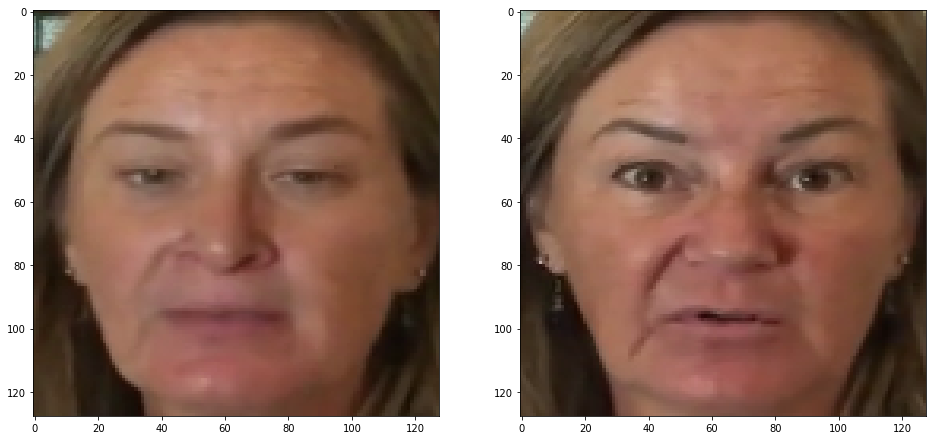

In [44]:
fig, (axf,axr) = plt.subplots(1,2, figsize=(16,8))
axf.imshow(ff[0])
axr.imshow(fr[0])
plt.show()

In [45]:
batch = 0
nsample = 300
d=128
vp = VideoProcessor()

while True:
    sample = df.query('label=="FAKE" and processed == False').sample(nsample)
    if len(sample) == 0:
        break

    fakes = np.empty(shape=(0,d,d,3), dtype=np.int8)
    reals = np.empty(shape=(0,d,d,3), dtype=np.int8)

    batch += 1
    for index, row in tqdm(sample.iterrows(), total=nsample):
        f = vp.extract_random_faces('../videos/' + row.dir + '/' + row.video)
        if len(f) > 0:
            fakes = np.append(fakes,f,axis=0)
        r = vp.extract_random_faces('../videos/' + row.dir + '/' + row.original)
        if len(r) > 0:
            reals = np.append(reals,r,axis=0)

    np.savez(f'../data/train_Xception_{batch}', fakes=fakes, reals=reals)
    df.loc[sample.index,'processed'] = f'train_Xception_{batch}'
    df.to_csv('../data/metadata_Xception.csv',index = False)
    print(f'saved batch: {batch}')

  0%|          | 0/300 [00:00<?, ?it/s]

saved batch: 1


  0%|          | 1/300 [00:07<34:58,  7.02s/it]

KeyboardInterrupt: 

In [ ]:
f[0].shape